In [88]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib

In [89]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


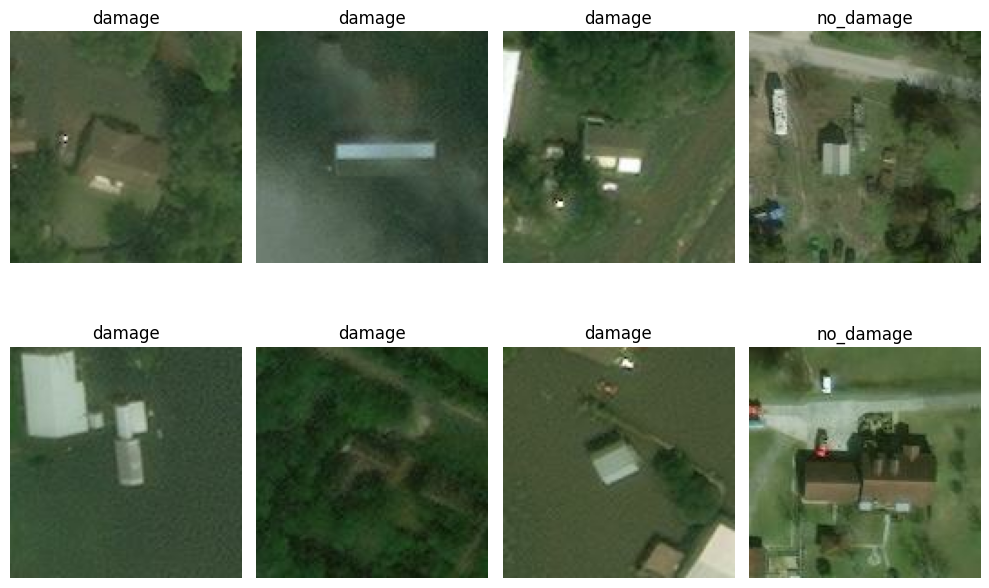

In [90]:
plt.figure(figsize=(10, 7))
images, labels = next(iter(train_ds))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [91]:
input_shape = img_size + (3,)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation"
)

rescale = layers.Rescaling(1./255)


In [92]:
def make_dense_ann(input_shape=input_shape):
    inputs = keras.Input(shape=input_shape)

    x = rescale(inputs)  # 0–1
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation="relu")(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="dense_ann")

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [93]:
def make_lenet5(input_shape=input_shape):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = rescale(x)

    # Conv1: 6 filters, 5x5
    x = layers.Conv2D(6, (5,5), activation="relu", padding="same")(x)
    x = layers.AveragePooling2D((2,2))(x)

    # Conv2: 16 filters, 5x5
    x = layers.Conv2D(16, (5,5), activation="relu", padding="same")(x)
    x = layers.AveragePooling2D((2,2))(x)

    # Conv3: 120 filters, 5x5
    x = layers.Conv2D(120, (5,5), activation="relu", padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(84, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="lenet5")

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [94]:
def make_alt_lenet(input_shape=input_shape):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = rescale(x)

    # Conv 32 → pool
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Conv 64 → pool
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Conv 128 → pool
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation="relu")(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="alt_lenet")

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [95]:
import os, json
os.makedirs("saved_models", exist_ok=True)
os.makedirs("server", exist_ok=True)

def train_model(model, name, epochs=15):
    ckpt_path = f"saved_models/{name}.keras"
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max"
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy", patience=4, restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", patience=2, factor=0.5
        ),
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1,
    )

    best_val_acc = max(history.history.get("val_accuracy", [0.0]))
    return history, best_val_acc, ckpt_path

histories = {}
scores = {}
paths = {}

for name, builder in {
    "dense": make_dense_ann,
    "lenet5": make_lenet5,
    "alt_lenet": make_alt_lenet,
}.items():
    print(f"\n=== Training {name} ===")
    model = builder()
    h, acc, path = train_model(model, name, epochs=15)
    histories[name] = h
    scores[name] = acc
    paths[name] = path

scores



=== Training dense ===
Epoch 1/15
34/34 [==============================] - 11s 312ms/step - loss: 6.5814 - accuracy: 0.5666 - val_loss: 0.8967 - val_accuracy: 0.2351 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - 11s 330ms/step - loss: 2.3432 - accuracy: 0.5955 - val_loss: 0.6567 - val_accuracy: 0.7687 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - 10s 286ms/step - loss: 0.8738 - accuracy: 0.6719 - val_loss: 0.3821 - val_accuracy: 0.8545 - lr: 0.0010
Epoch 4/15
34/34 [==============================] - 9s 279ms/step - loss: 0.5277 - accuracy: 0.7344 - val_loss: 0.4011 - val_accuracy: 0.8731 - lr: 0.0010
Epoch 5/15
34/34 [==============================] - 9s 273ms/step - loss: 0.4518 - accuracy: 0.7754 - val_loss: 0.4004 - val_accuracy: 0.9104 - lr: 0.0010
Epoch 6/15
34/34 [==============================] - 5s 155ms/step - loss: 0.4286 - accuracy: 0.8034 - val_loss: 0.3525 - val_accuracy: 0.8769 - lr: 5.0000e-04
Epoch 7/15
34/34 [=====================

{'dense': 0.9104477763175964,
 'lenet5': 0.9589552283287048,
 'alt_lenet': 0.9925373196601868}

In [96]:
import shutil

best_name = max(scores, key=scores.get)
best_path = paths[best_name]

print("Best model:", best_name, "val_acc:", scores[best_name])

shutil.copy(best_path, "saved_models/best_model.keras")

model_card = {
    "model_name": best_name,
    "framework": "tensorflow-keras",
    "input_shape": input_shape,
    "classes": class_names,
    "metrics": {"best_val_accuracy": float(scores[best_name])},
}
with open("server/model_card.json", "w") as f:
    json.dump(model_card, f, indent=2)


Best model: alt_lenet val_acc: 0.9925373196601868


In [97]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

best_model = keras.models.load_model("saved_models/best_model.keras")

y_true = []
y_prob = []

for x_batch, y_batch in val_ds:
    probs = best_model.predict(x_batch, verbose=0).ravel()
    y_prob.append(probs)
    y_true.append(y_batch.numpy().ravel())

y_true = np.concatenate(y_true)
y_prob = np.concatenate(y_prob)
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
print("Confusion matrix:\n", cm)

try:
    auc = roc_auc_score(y_true, y_prob)
except ValueError:
    auc = None

print("ROC-AUC:", auc)
print("\nClassification report:\n",
      classification_report(y_true, y_pred, target_names=class_names))


Confusion matrix:
 [[206   0]
 [  2  60]]
ROC-AUC: 0.9998434074538052

Classification report:
               precision    recall  f1-score   support

      damage       0.99      1.00      1.00       206
   no_damage       1.00      0.97      0.98        62

    accuracy                           0.99       268
   macro avg       1.00      0.98      0.99       268
weighted avg       0.99      0.99      0.99       268



In [98]:
import tensorflow as tf

model = tf.keras.models.load_model("saved_models/best_model.keras")
model.summary()


Model: "alt_lenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 128, 128, 3)       0         
 ial)                                                            
                                                                 
 rescaling_5 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 64)        18